In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
warnings.filterwarnings('ignore')

In [2]:
Block1=pd.read_csv('Blocks/Block 1.csv')
test=pd.read_csv('test.csv')

# Block 1 的各个特征核密度估计

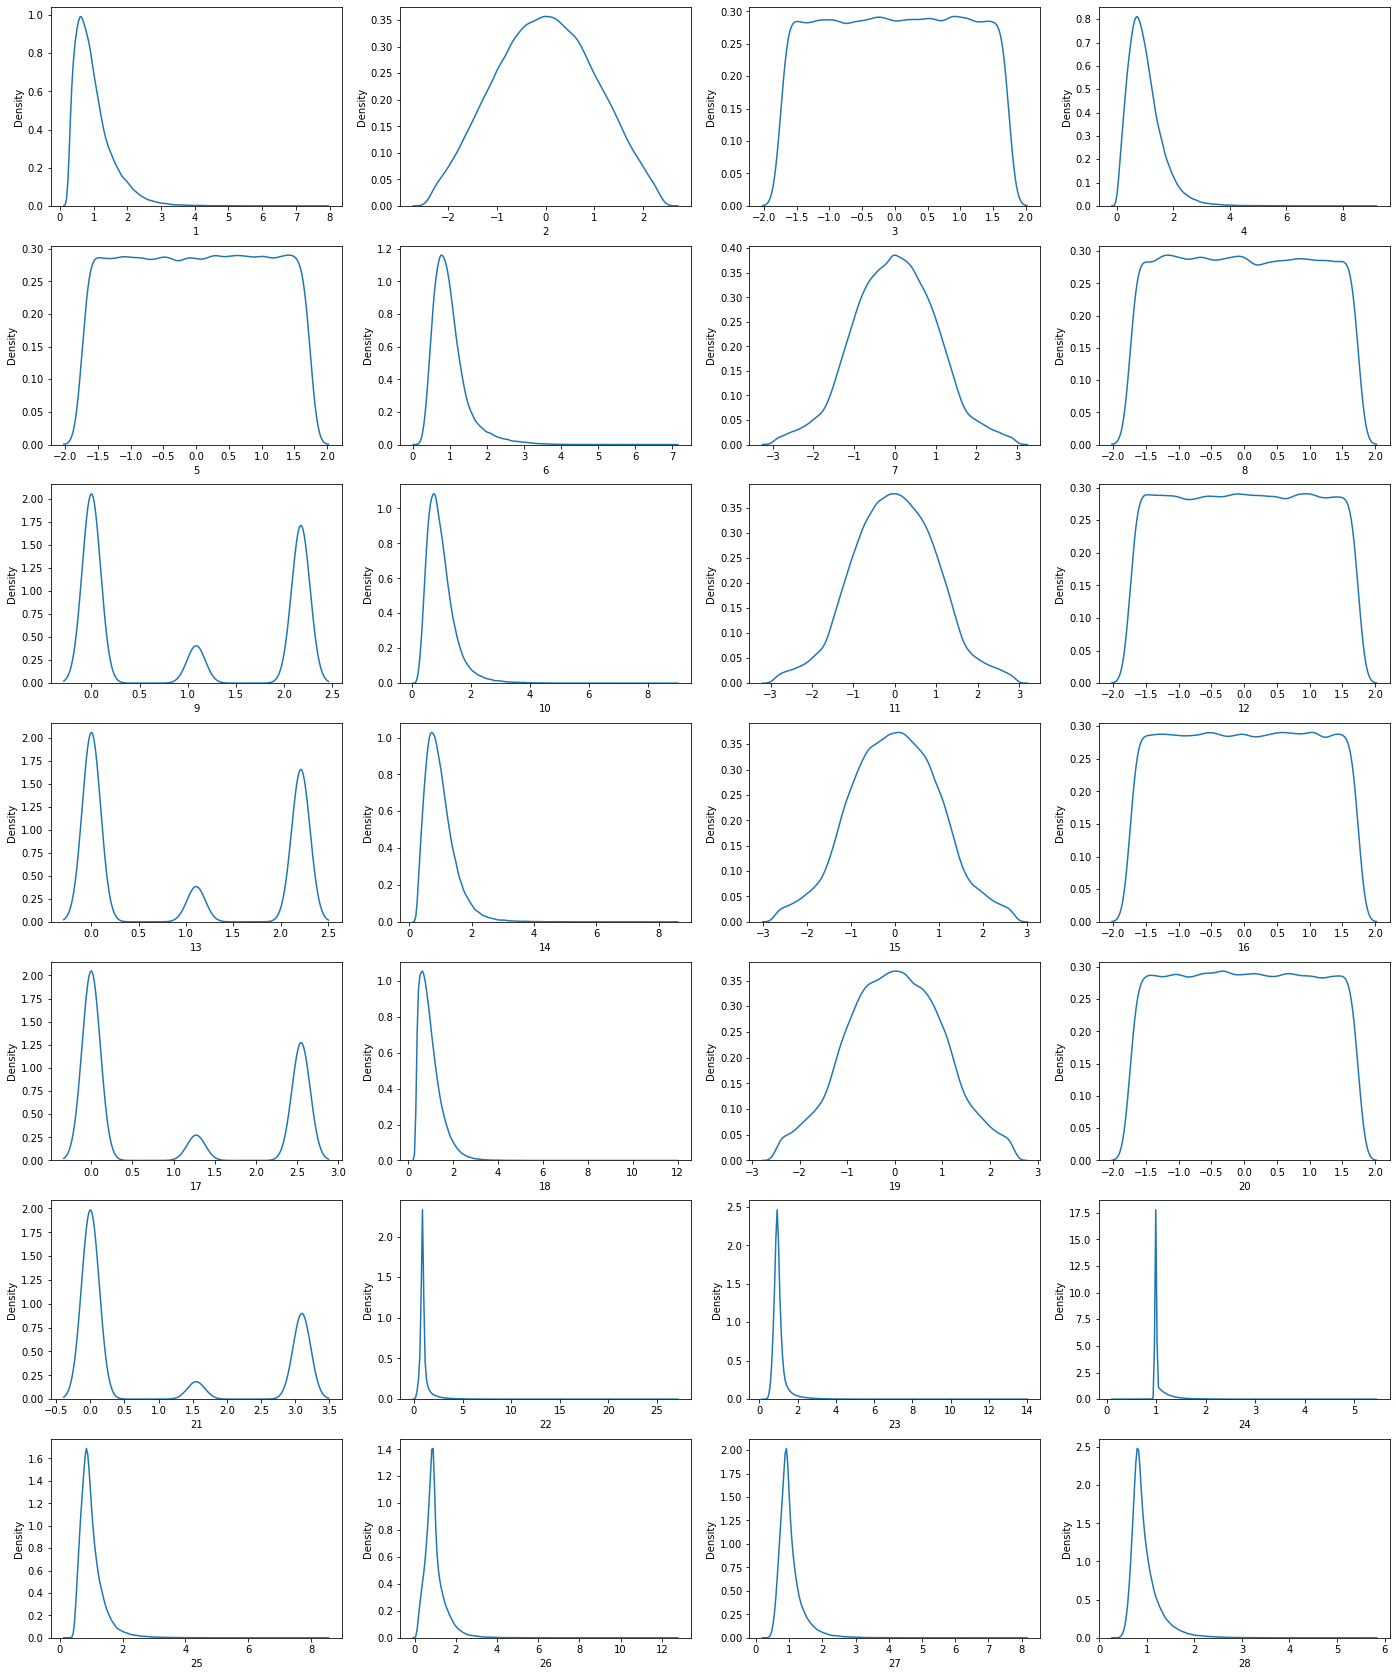

In [12]:
%matplotlib inline
fig,ax=plt.subplots(7,4,figsize=(24,30))
for i in range(7):
    for j in range(4):
        k=i*4+j+1
        sns.distplot(Block1[str(k)],hist=False,ax=ax[i][j])

        

In [248]:
# 测试集的X和Y
X_test=test.drop('label',axis=1)
Y_test=test['label']

# Decision Tree

## 这里不重要，可以水一下报告

### 在Block 1上使用全部特征 

In [3]:
X=Block1.drop('label',axis=1)
Y=Block1['label']

X_test=test.drop('label',axis=1)
Y_test=test['label']

clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X,Y)

DecisionTreeClassifier(criterion='entropy')

In [13]:
clf.score(X_test,Y_test)

0.6356387878787879

### 去除列22~28后，用Decision Tree

In [21]:
X_p=Block1.drop(['label','22','23','24','25','26','27','28'],axis=1)
Y_p=Block1['label']

X_test_p=test.drop(['label','22','23','24','25','26','27','28'],axis=1)
Y_test_p=test['label']

clf_p = DecisionTreeClassifier(criterion='entropy')
clf_p.fit(X_p,Y_p)

DecisionTreeClassifier(criterion='entropy')

In [22]:
clf_p.score(X_test_p,Y_test_p)

0.5621042424242424

# MLP+Softmax

In [3]:
# Xavier初始化权重

def xavier(m):
    if type(m)==nn.Linear:
        nn.init.xavier_uniform_(m.weight)

class MyNet(nn.Module):
    def __init__(self,input_dim):
        super().__init__()
        self.f1=nn.Linear(input_dim,input_dim*2)
        self.drop1=nn.Dropout(p=0.2)
        self.s1=nn.Sigmoid()
        
        self.f2=nn.Linear(input_dim*2,input_dim*2)
        self.drop2=nn.Dropout(p=0.5)
        self.s2=nn.Sigmoid()
        
        self.f3=nn.Linear(input_dim*2,input_dim)
        self.drop3=nn.Dropout(p=0.2)
        self.s3=nn.Sigmoid()
        
        self.f4=nn.Linear(input_dim,2)
        self.s4=nn.Softmax(dim=1)
        
#         self.net=nn.Sequential(
#             nn.Linear(input_dim,input_dim*2),nn.Dropout(0.2),nn.Sigmoid(),
#             nn.Linear(input_dim*2,input_dim*2),nn.Dropout(0.5),nn.Sigmoid(),
#             nn.Linear(input_dim*2,input_dim),nn.Dropout(0.2),nn.Sigmoid(),
#             nn.Linear(input_dim,2),nn.Softmax(dim=1),
#         ).to(torch.device('cuda:0'))
        
    
    def forward(self,x):
        x=self.s1(self.drop1(self.f1(x)))
        x=self.s2(self.drop2(self.f2(x)))
        x=self.s3(self.drop3(self.f3(x)))
        return self.s4(self.f4(x))   
        
#     预测
    def predict(self,x):
        x=self.s1(self.f1(x))
        x=self.s2(self.f2(x))
        x=self.s3(self.f3(x))
        p=self.s4(self.f4(x))         
        return (p[:,0]<p[:,1])
    
#     准确率 
    def acc(self,x,y):
        with torch.no_grad():
            return float(((self.predict(x)==y).sum()/len(y)))

### 测试管道

In [82]:
X_test=torch.FloatTensor(test.drop('label',axis=1).values).to(torch.device('cuda:0'))
Y_test=torch.LongTensor(test['label'].values).to(torch.device('cuda:0'))

### 制作训练管道

In [5]:
X=torch.FloatTensor(Block1.drop('label',axis=1).values).to(torch.device('cuda:0'))
Y=torch.LongTensor(Block1['label'].values).to(torch.device('cuda:0'))

# train_iter=DataLoader(
#     TensorDataset(
#         X,
#         Y
#     ),
#     batch_size=2**17,
#     shuffle=True,
# )


### 模型和基本参数

In [6]:
# net
net=MyNet(X.shape[1]).cuda('cuda:0') #放到gpu
net.apply(xavier);# xavier初始化参数


In [7]:
# 用于绘制曲线
losses=[]
train_acc=[]
test_acc=[]

### 可以边训练边改参数

In [68]:
optimizer=torch.optim.Adam(net.parameters(), lr=0.012, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0000001, amsgrad=True)
criterion=torch.nn.CrossEntropyLoss()
epochs=100000


for i in range(epochs):
    
    y_pred=net.forward(X)
    loss=criterion(y_pred,Y)
    

    if(i%100)==0:
        losses.append(float(loss))
        train_acc.append( net.acc(X,Y) )
        test_acc.append(net.acc(X_test,Y_test))
    if(i%(int(epochs*0.1))==0):
        print(str((i/epochs)*100)+'%',end='\t')
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print('100%')
torch.save(net.state_dict(),'Params/Net1/Net1_'+str(len(train_acc)*100)+'.params')


0.0%	10.0%	20.0%	30.0%	40.0%	50.0%	60.0%	70.0%	80.0%	90.0%	100%


epoch: 226000
Train acc:  0.7356623411178589
Test acc:   0.7305105924606323


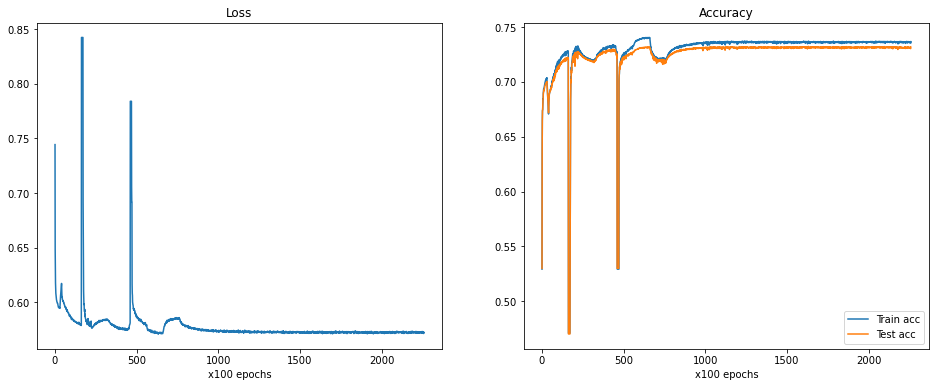

In [78]:
%matplotlib inline
fig,ax=plt.subplots(1,2,figsize=(16,6))

ax[0].set_xlabel('x100 epochs')
ax[0].set_title('Loss')
ax[0].plot(   losses,label='Train loss')
ax[1].plot(train_acc,label='Train acc')
ax[1].plot( test_acc,label='Test acc')
ax[1].set_xlabel('x100 epochs')
ax[1].set_title('Accuracy')

plt.legend()
print('epoch: '+str(len(train_acc*100)))
print('Train acc: ',net.acc(X,Y))
print('Test acc:  ',net.acc(X_test,Y_test))

### epoch: 226000
可以看到这个模型应该是达到上限了，至少没有过拟合, 一个RSP 154000条记录

In [70]:
# %matplotlib qt5
# fig,ax=plt.subplots(1,2,figsize=(16,6))

# ax[0].plot(losses,label='Train loss')
# ax[0].set_xlabel('x100 epochs')
# ax[0].set_title('Loss')
# ax[1].plot(train_acc,label='Train acc')
# ax[1].plot(test_acc,label='Test acc')
# ax[1].set_xlabel('x100 epochs')
# ax[1].set_title('Accuracy')

# plt.legend()
# print('Train acc: ',net.acc(X,Y))
# print('Test acc:  ',net.acc(X_test,Y_test))

Train acc:  0.7356623411178589
Test acc:   0.7305105924606323
